Lets clone our repository initially

In [ ]:
!git clone   https://github.com/chel310/Trash_classifier.git 
%cd Trash_classifier/

Cloning into 'Trash_classifier'...
remote: Enumerating objects: 28888, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 28888 (delta 51), reused 44 (delta 11), pack-reused 28760
Receiving objects: 100% (28888/28888), 946.14 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking out files: 100% (16732/16732), done.
/content/Trash_classifier/Trash_classifier


We will be using tensorflow as our default library for transfer learning. Code uasge  was based on [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for the same

In [ ]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

Lets load our training images for processing

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
data_root = 'dataset_augmented/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14182 files belonging to 5 classes.
Using 11346 files for training.


In [ ]:
class_names = np.array(train_ds.class_names)
print('class names for predictions :',class_names)

class names for predictions : ['cardboard' 'metal' 'paper' 'plastic' 'trash']


TensorFlow Hub's conventions for image models is to expect **float** inputs in the **[0, 1]** range. Use the **Rescaling layer** to achieve this.

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))


Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
image_batch.shape

TensorShape([32, 224, 224, 3])

# Train the model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

 To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=5,
                    callbacks=[batch_stats_callback])


Epoch 1/5
355/355 [==============================] - 35s 69ms/step - loss: 0.3432 - acc: 0.8889
Epoch 2/5
355/355 [==============================] - 15s 42ms/step - loss: 0.2191 - acc: 0.8889
Epoch 3/5
355/355 [==============================] - 15s 42ms/step - loss: 0.1554 - acc: 0.8889
Epoch 4/5
355/355 [==============================] - 15s 42ms/step - loss: 0.1128 - acc: 0.9444
Epoch 5/5
355/355 [==============================] - 15s 42ms/step - loss: 0.0870 - acc: 0.9444


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

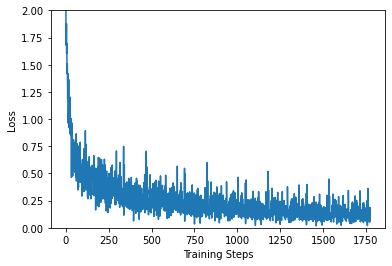

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

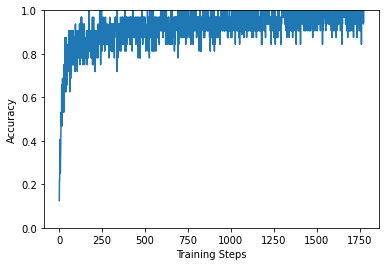

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

To redo the plot from before, first get the ordered list of class names:



In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


1/1 [==============================] - 0s 435ms/step


Plot the result

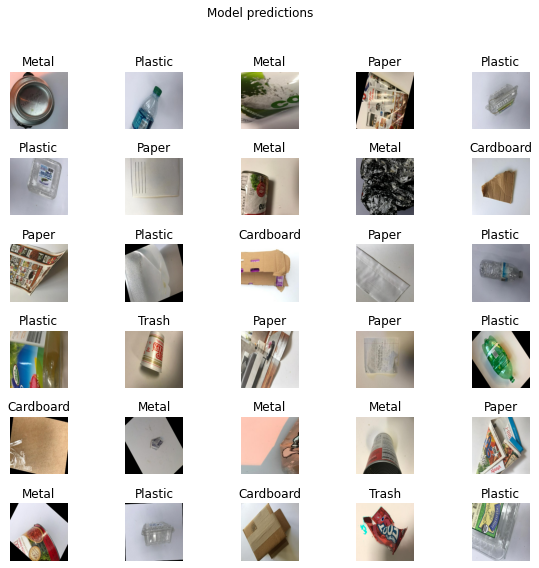

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")


## Save the Model

In [ ]:
t = time.time()

export_path = "saved_models/MobileNetV2"
model.save(export_path)

export_path

'saved_models/MobileNetV2'